## AllLife Credit Card Customer Segmentation

<b>Background:</b> AllLife Bank wants to focus on its credit card customer base in the next financial  year.  They  have  been  advised  by  their  marketing  research  team,  that  the penetration  in  the  market  can  be  improved. Based  on  this  input,  the  Marketing  team proposes to run personalised campaigns to target new customers as well as upsell to existing  customers.  Another  insight from  the market  research  was  that  the  customers perceive the support services of the back poorly. Based on this, the Operations team wants  to  upgrade  the  service  delivery  model,  to  ensure  that  customers  queries  are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

<b> Objective: </b> To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

<b> Key Questions: </b>
1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What are your recommendations to the bank on how to better market to and
service these customers?

In [33]:
### importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from scipy.stats import zscore
from sklearn.cluster import KMeans

In [2]:
### reading data
df = pd.read_excel('Credit Card Customer Data.xlsx')
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [3]:
df.tail()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0
659,660,80150,167000,9,0,12,2


In [5]:
df.shape

(660, 7)

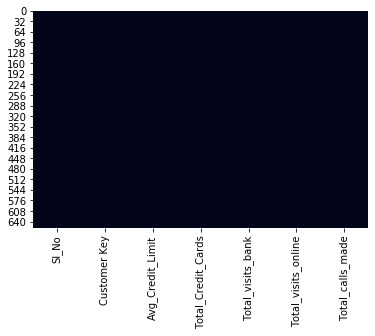

In [8]:
##verifying for missing data
sns.heatmap(df.isnull(), cbar=False);

Good, no missing data

In [15]:
df_data = df[['Avg_Credit_Limit','Total_Credit_Cards','Total_visits_online','Total_calls_made']]

### 1 - Univariate Analysis.

In [23]:
df_data.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000
mean,34574.242424,4.706061,2.606061,3.583333
std,37625.487804,2.167835,2.935724,2.865317
min,3000.000000,1.000000,0.000000,0.000000
25%,10000.000000,3.000000,1.000000,1.000000
50%,18000.000000,5.000000,2.000000,3.000000
75%,48000.000000,6.000000,4.000000,5.000000
max,200000.000000,10.000000,15.000000,10.000000


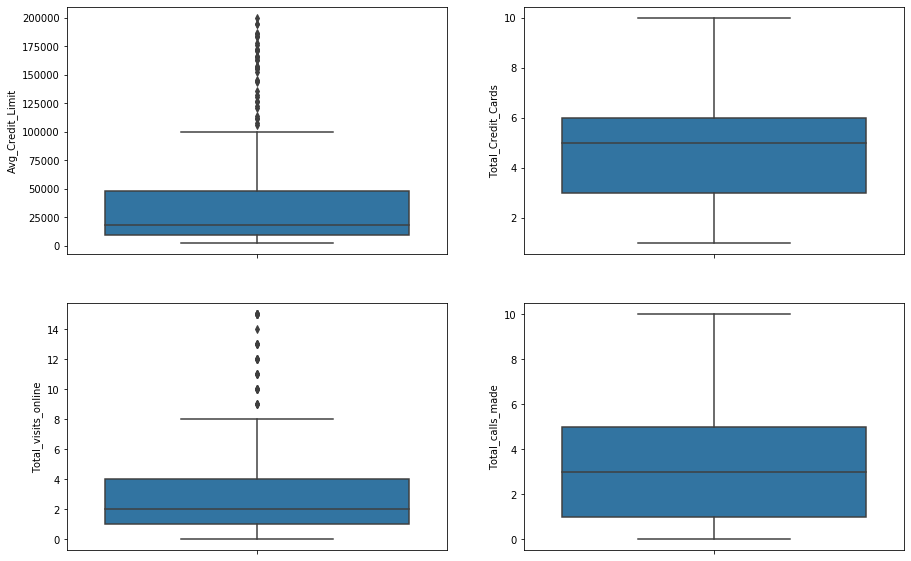

In [26]:
fix, ax = plt.subplots(2,2, figsize=(15,10))
for var, subplot in zip(df_data.columns, ax.flatten()):
    sns.boxplot(y=var, data=df_data, ax=subplot)

Both boxplot and describe on df_data dataframe shows that data is on a different range for each variable. Also, we have some outliers in our data for total visits and credit card limit.

Let`s verify how correlated is the data:

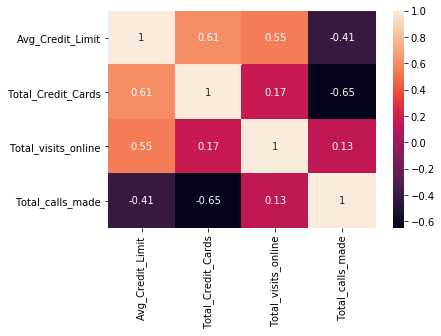

In [27]:
sns.heatmap(df_data.corr(), annot=True)

By the plot above we can see that there is a slight negative correlation between the total of credit cards and the total calls made. Same for the average credit limit. This can be a clue for the number of principal components to be applied on this dataset.

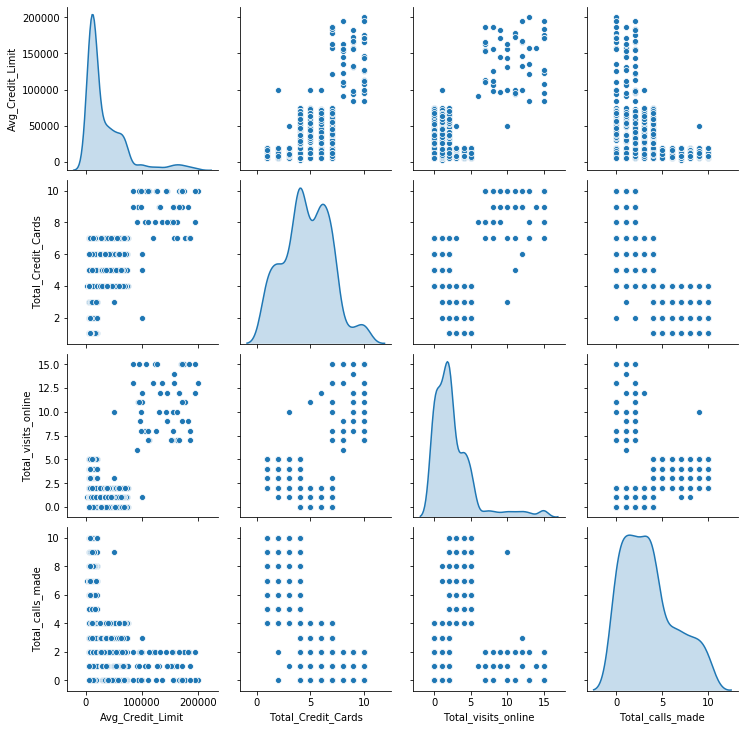

In [21]:
sns.pairplot(df_data, diag_kind='kde');

By this plot (the number of peaks found in main diagonal) we can see that for a clustering task, we may have <font color=red><b> at least 5 clusters </b></font>. Lets check it out using a K-means and elbow method.

### Data Preparation

Next, I`m going to apply zscore normalization on this data in order to have all data in the same scale: standard deviations.

In [59]:
df_prep = df_data.apply(zscore)
df_prep.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_online,Total_calls_made
count,6.600000e+02,6.600000e+02,6.600000e+02,6.600000e+02
mean,8.195465e-16,-4.006223e-15,1.944572e-16,-7.112156e-16
std,1.000758e+00,1.000758e+00,1.000758e+00,1.000758e+00
min,-8.398081e-01,-1.710864e+00,-8.883795e-01,-1.251537e+00
25%,-6.536229e-01,-7.875852e-01,-5.474897e-01,-9.022711e-01
50%,-4.408398e-01,1.356941e-01,-2.065999e-01,-2.037386e-01
75%,3.570968e-01,5.973337e-01,4.751797e-01,4.947938e-01
max,4.399975e+00,2.443892e+00,4.224968e+00,2.241125e+00


By the mean of all columns being around 0 and std being around 1, shows that zscore was sucessfully applied.

Let`s check again the pairplot to see if the number of clusters may still be 5 as we previously found.

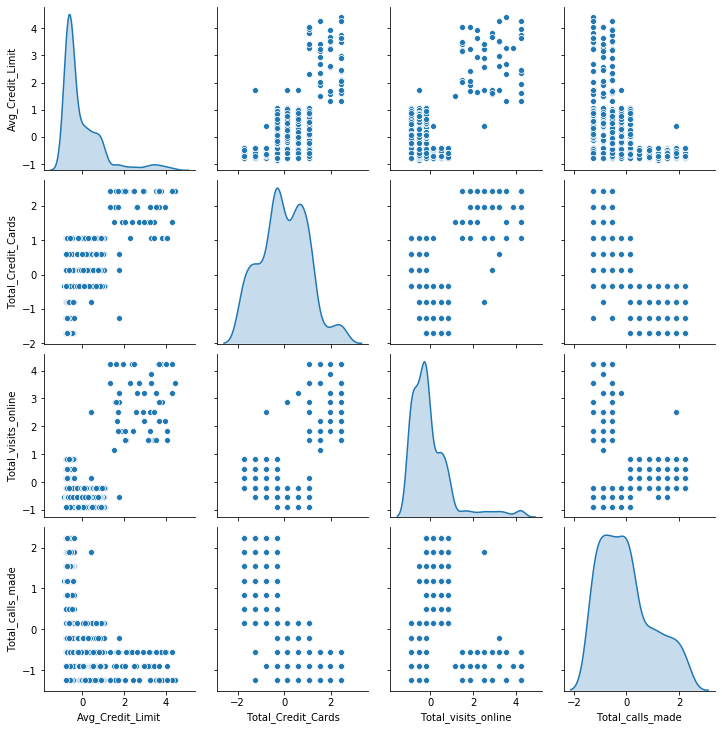

In [31]:
sns.pairplot(df_prep, diag_kind='kde');

That`s good, nothing changed.

I`ll try untill 20 clusters.

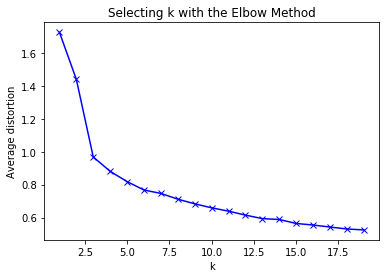

In [63]:
clusters=range(1,20)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k, random_state=1)
    model.fit(df_prep)
    prediction=model.predict(df_prep)
    meanDistortions.append(sum(np.min(cdist(df_prep, model.cluster_centers_, 'euclidean'), axis=1)) / df_prep.shape[0])


ax = plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method');

By the elbow method I'd say that we can choose 5 or 7 clusters at most. This is because after 5 clusters there is little or almost no change in the average distortion between clusters.

Let`s evaluate the models with k=5, 6 and 7.

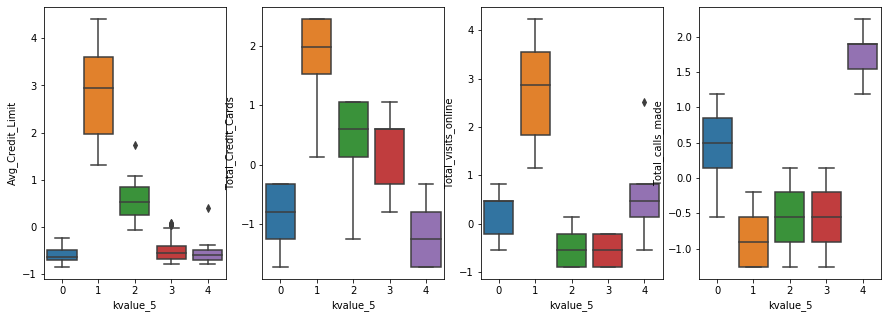

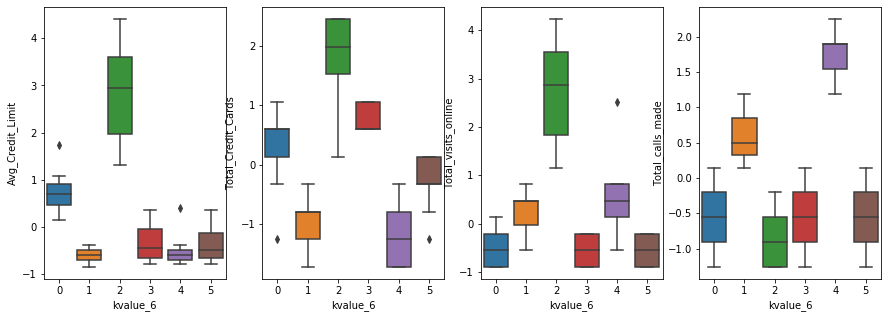

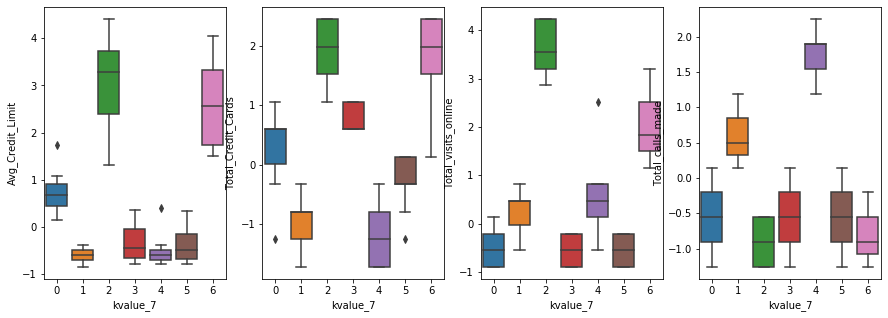

In [64]:
k_values = [5,6,7]

for k in k_values:
    mdl = KMeans(k, random_state=1)
    mdl.fit(df_prep)
    pred = mdl.predict(df_prep)
    
    df_prep['kvalue_'+str(k)] = pred
    
    fix, ax = plt.subplots(1,4, figsize=(15,5))
    for var, subplot in zip(df_prep.columns, ax.flatten()):
        sns.boxplot(y=var, x='kvalue_'+str(k), data=df_prep, ax=subplot)
        
    df_prep.drop('kvalue_'+str(k), axis=1, inplace=True)
    #sns.boxplot()

In our first line of boxplots we have five clusters. In cluster 1 we have the guys with highest credit limit, total credit cards and total call made. For k=6 and k=7 we can also notice some clusters with high values for these variables too. So, for sure its a distinct segment of customers on the whole dataset